In [11]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, time

def plot_predicted_energy_consumption():
    # Plot styling
    plt.style.use('ggplot')
    sns.set_palette("Blues")

    # Connect to the database
    conn = sqlite3.connect("database.db")

    # Query predicted energy consumption
    pred_query = """
    SELECT timestamp, power_consumption
    FROM predictions
    ORDER BY timestamp
    """
    pred_df = pd.read_sql_query(pred_query, conn)
    conn.close()

    # Convert timestamp to datetime
    pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp'])

    # Calculate a moving average over a 2-hour window (2h * 60min / 5min = 24 intervals)
    interval_minutes = 5
    moving_avg_window = int((2 * 60) / interval_minutes)
    pred_df['moving_avg'] = pred_df['power_consumption'].rolling(window=moving_avg_window).mean()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(pred_df['timestamp'], pred_df['power_consumption'],
             color=sns.color_palette("Blues", 1)[0], alpha=0.7, linewidth=2, label='Predicted Consumption')
    plt.plot(pred_df['timestamp'], pred_df['moving_avg'],
             color='green', alpha=0.8, linewidth=2, label='2-Hour Moving Average')

    # Get unique dates in the dataset
    unique_dates = pred_df['timestamp'].dt.date.unique()

    # Add vertical lines at midnight for each day change
    for date in unique_dates[1:]:  # Skip the first date since we want lines between days
        midnight = datetime.combine(date, time.min)
        plt.axvline(x=midnight, color='red', linestyle='--', alpha=1,
                    label='Day Change' if date == unique_dates[1] else "")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %a %H:%M'))  # Added %d for date number
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
    plt.xticks(rotation=45)

    plt.title("Predicted Total Energy Consumption", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Power Consumption (W)", fontsize=12)
    plt.grid(True, alpha=0.3)

    # Handle legend (ensuring day change only appears once in legend)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) 
                    if l not in labels[:i]]
    plt.legend(*zip(*unique_labels), loc='upper left')

    # Fix for x-axis extension issue - set limits to match exactly with data
    plt.xlim(pred_df['timestamp'].min(), pred_df['timestamp'].max())

    plt.tight_layout()
    plt.show()
def plot_energy_consumption_with_tasks():
    # Plot styling
    plt.style.use('ggplot')
    sns.set_palette("Blues")

    # Connect to the database
    conn = sqlite3.connect("database.db")

    # Query predicted energy consumption
    pred_query = """
    SELECT timestamp, power_consumption
    FROM predictions
    ORDER BY timestamp
    """
    pred_df = pd.read_sql_query(pred_query, conn)

    # Query scheduled tasks
    task_query = """
    SELECT scheduled_time, switch_id
    FROM scheduled_tasks
    WHERE scheduled_time IS NOT NULL
    ORDER BY scheduled_time
    """
    task_df = pd.read_sql_query(task_query, conn)
    conn.close()

    # Convert timestamps
    pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp'])
    task_df['scheduled_time'] = pd.to_datetime(task_df['scheduled_time'])

    # Calculate 2-hour moving average
    interval_minutes = 5
    moving_avg_window = int((2 * 60) / interval_minutes)
    pred_df['moving_avg'] = pred_df['power_consumption'].rolling(window=moving_avg_window).mean()

    # --- PLOT ---
    plt.figure(figsize=(14, 6))

    # Plot predicted power and moving average
    plt.plot(pred_df['timestamp'], pred_df['power_consumption'],
             color=sns.color_palette("Blues", 1)[0], alpha=0.7, linewidth=2, label='Predicted Consumption')
    plt.plot(pred_df['timestamp'], pred_df['moving_avg'],
             color='green', alpha=0.8, linewidth=2, label='2-Hour Moving Average')

    # Colors for X markers (cycle through these colors)
    x_colors = ['red', 'yellow', 'pink', 'orange']

    # Add task X markers directly on the moving avg
    if not task_df.empty:
        for i, row in task_df.iterrows():
            sched_time = row['scheduled_time']
            switch_id = row['switch_id']

            # Find matching moving avg value (exact or nearest)
            closest_idx = pred_df['timestamp'].sub(sched_time).abs().idxmin()
            y_value = pred_df.loc[closest_idx, 'moving_avg']

            # Plot X on moving avg with cycling colors
            plt.scatter(sched_time, y_value, marker='X', s=100, color=x_colors[i % len(x_colors)], label=None, zorder=5)

    # Day change markers
    unique_dates = pred_df['timestamp'].dt.date.unique()
    for date in unique_dates[1:]:
        midnight = datetime.combine(date, time.min)
        plt.axvline(x=midnight, color='red', linestyle='--', alpha=1,
                    label='Day Change' if date == unique_dates[1] else "")

    # Axis formatting
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %a %H:%M'))  # Added %d for date number
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
    plt.xticks(rotation=45)

    # Labels and title
    plt.title("Predicted Total Energy Consumption", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Power Consumption (W)", fontsize=12)
    plt.grid(True, alpha=0.3)

    # Legend (cleaned up)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    plt.legend(*zip(*unique_labels), loc='upper left')

    # Preserve x-axis limits
    plt.xlim(pred_df['timestamp'].min(), pred_df['timestamp'].max())

    plt.tight_layout()
    plt.show()

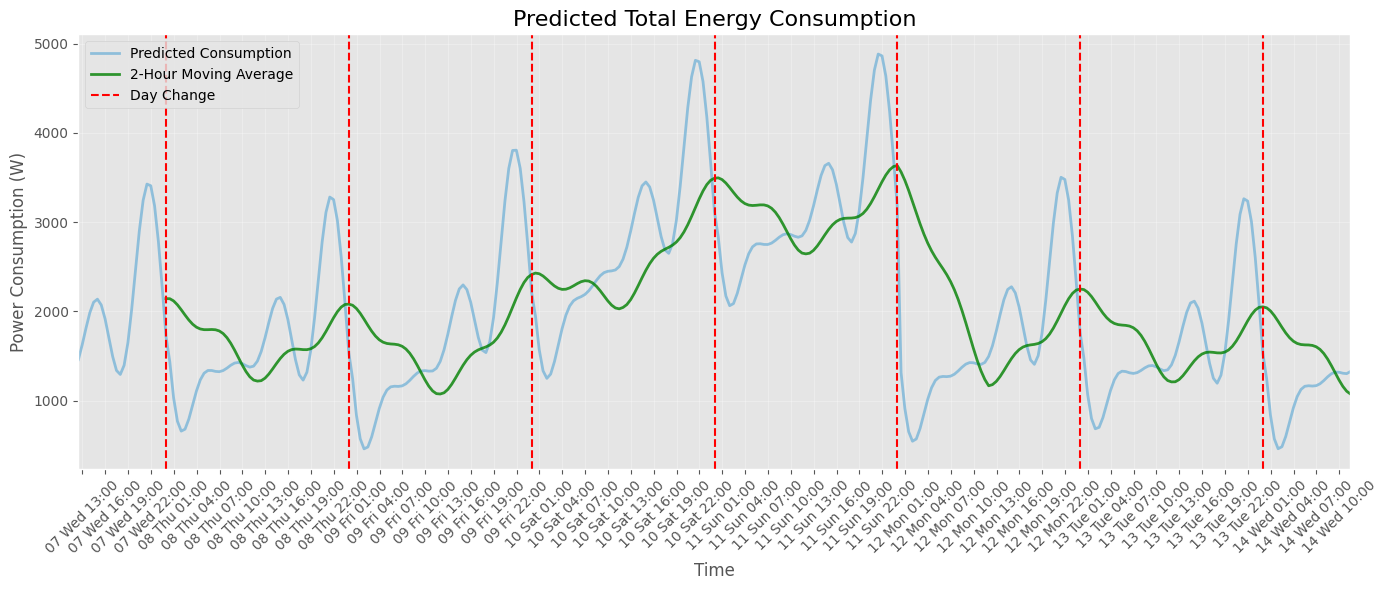

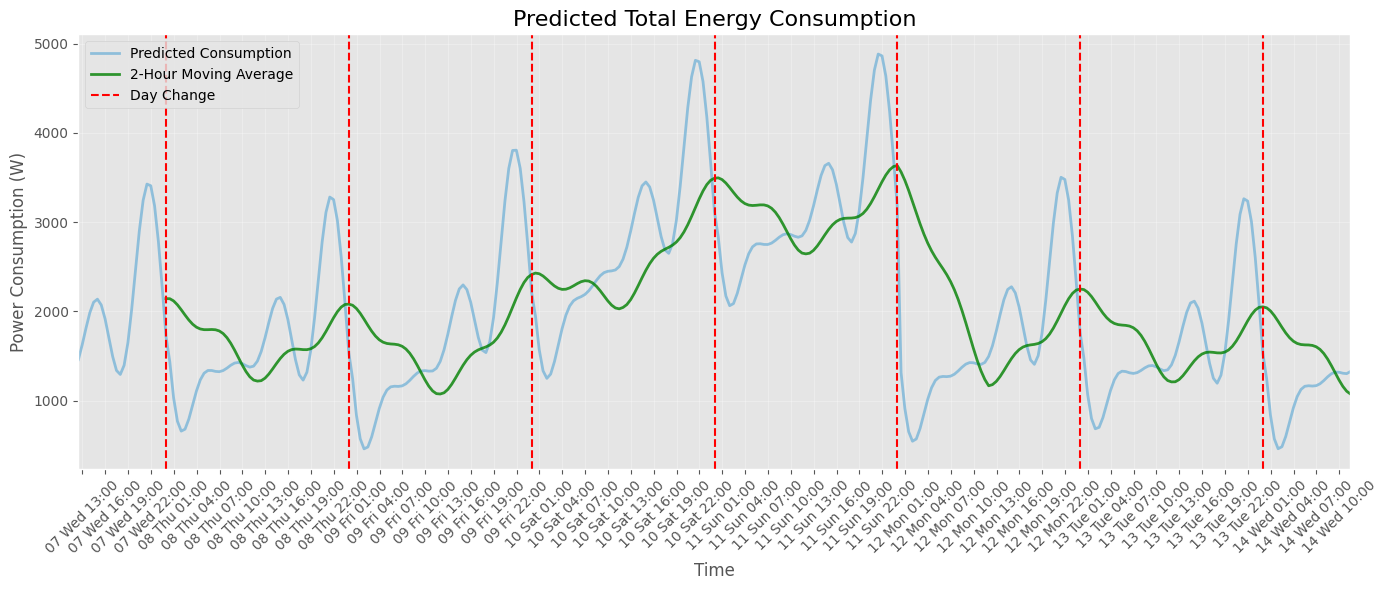

In [12]:
plot_predicted_energy_consumption()
plot_energy_consumption_with_tasks()